# Blood-Brain Barrier Permeability Prediction
## Traditional Machine Learning Methods

This notebook uses various traditional ML approaches for predicting BBB permeability using the B3DB_classification dataset.

### Experiments:
1. **Logistic Regression** with different feature representations
2. **Random Forest** with hyperparameter tuning
3. **XGBoost** classifier
4. **Ensemble Methods**
5. **Class Imbalance Handling** comparisons [SMOTE,class weighting]
6. **PCA-based Feature Selection**

### Features:
- Molecular Descriptors (RDKit)
- MACCS Fingerprints
- Morgan Fingerprints
- Combined features

## 1. Import Required Libraries

In [3]:
# Data manipulation
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# RDKit for molecular features
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, Crippen, AllChem, MACCSkeys, rdFingerprintGenerator

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             classification_report, confusion_matrix, roc_curve, auc,
                             precision_recall_curve, average_precision_score, roc_auc_score)

# XGBoost
import xgboost as xgb

# Imbalanced-learn for class imbalance
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("All libraries imported successfully!")

All libraries imported successfully!


## 2. Load and Explore Dataset

In [4]:
# Load B3DB classification dataset
df = pd.read_csv('../data/B3DB_classification.tsv', sep='\t')

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nColumn names: {df.columns.tolist()}")
print(f"\nClass distribution:")
print(df['BBB+/BBB-'].value_counts())
print(f"\nClass proportions:")
print(df['BBB+/BBB-'].value_counts(normalize=True))

# Check for missing values
print(f"\nMissing values:")
print(df.isnull().sum())

Dataset shape: (7807, 12)

First few rows:
   NO.                        compound_name  \
0    1                       sulphasalazine   
1    2                           moxalactam   
2    3                           clioquinol   
3    4  bbcpd11 (cimetidine analog) (y-g13)   
4    5                        schembl614298   

                                          IUPAC_name  \
0  2-hydroxy-5-[[4-(pyridin-2-ylsulfamoyl)phenyl]...   
1  7-[[2-carboxy-2-(4-hydroxyphenyl)acetyl]amino]...   
2                       5-chloro-7-iodoquinolin-8-ol   
3  2-[2-[(3-bromopyridin-2-yl)methylsulfanyl]ethy...   
4  (2s,3s,4s,5r)-6-[[(4r,4ar,7s,7ar,12bs)-7-hydro...   

                                              SMILES         CID  logBB  \
0   O=C(O)c1cc(N=Nc2ccc(S(=O)(=O)Nc3ccccn3)cc2)ccc1O      5339.0  -2.69   
1  COC1(NC(=O)C(C(=O)O)c2ccc(O)cc2)C(=O)N2C(C(=O)...      3889.0  -2.52   
2                             Oc1c(I)cc(Cl)c2cccnc12      2788.0  -2.40   
3                         CCNC(=NCCSC

## 3. Feature Extraction

We'll extract three types of molecular features:
1. **Molecular Descriptors** - physico-chemical properties (MW, LogP, TPSA, etc.)
2. **MACCS Keys** - 166-bit structural fingerprints [each bit has fixed meaning]
3. **Morgan Fingerprints** - circular fingerprints (2048-bit) [substructures are hashed to get bit no]

In [5]:
### 3.1 Molecular Descriptors
def calculate_molecular_descriptors(smiles):
    """Calculate molecular descriptors from SMILES"""
    mol = Chem.MolFromSmiles(smiles)
    
    if mol is None:
        return None
    
    descriptors = {
        'MolWt': Descriptors.MolWt(mol),
        'LogP': Crippen.MolLogP(mol),
        'NumHDonors': Lipinski.NumHDonors(mol),
        'NumHAcceptors': Lipinski.NumHAcceptors(mol),
        'TPSA': Descriptors.TPSA(mol),
        'NumRotatableBonds': Lipinski.NumRotatableBonds(mol),
        'NumAromaticRings': Lipinski.NumAromaticRings(mol),
        'NumHeteroatoms': Lipinski.NumHeteroatoms(mol),
        'NumRings': Lipinski.RingCount(mol),
        'FractionCsp3': Lipinski.FractionCSP3(mol),
        'NumSaturatedRings': Lipinski.NumSaturatedRings(mol),
        'NumAliphaticRings': Lipinski.NumAliphaticRings(mol),
    }
    
    return descriptors

# Calculate descriptors for all molecules
descriptor_list = []
valid_indices = []

for idx, smiles in enumerate(df['SMILES']):
    desc = calculate_molecular_descriptors(smiles)
    if desc is not None:
        descriptor_list.append(desc)
        valid_indices.append(idx)

descriptors_df = pd.DataFrame(descriptor_list)
print(f"Molecular descriptors shape: {descriptors_df.shape}")
print(f"Valid molecules: {len(valid_indices)}/{len(df)}")
print(f"\nDescriptor statistics:")
print(descriptors_df.describe())

[02:20:01] Explicit valence for atom # 10 C, 4, is greater than permitted


Molecular descriptors shape: (7805, 12)
Valid molecules: 7805/7807

Descriptor statistics:
             MolWt         LogP   NumHDonors  NumHAcceptors         TPSA  \
count  7805.000000  7805.000000  7805.000000    7805.000000  7805.000000   
mean    385.458917     2.355938     2.010250       5.418962    87.009775   
std     170.887422     2.195739     2.262705       3.696626    67.689087   
min       6.941000    -8.895300     0.000000       0.000000     0.000000   
25%     285.343000     1.202100     1.000000       3.000000    41.490000   
50%     362.466000     2.547800     1.000000       4.000000    72.680000   
75%     451.607000     3.786400     3.000000       7.000000   107.610000   
max    1882.332000    12.605800    24.000000      33.000000   662.410000   

       NumRotatableBonds  NumAromaticRings  NumHeteroatoms     NumRings  \
count        7805.000000       7805.000000     7805.000000  7805.000000   
mean            4.770788          1.318258        7.034721     3.267521   

[02:20:03] Explicit valence for atom # 10 C, 4, is greater than permitted


In [6]:
### 3.2 MACCS Fingerprints
def calculate_maccs_fingerprints(smiles):
    """Calculate MACCS keys fingerprints"""
    mol = Chem.MolFromSmiles(smiles)
    
    if mol is None:
        return None
    
    maccs = MACCSkeys.GenMACCSKeys(mol)
    return np.array(maccs)

maccs_list = []

for idx in valid_indices:
    smiles = df.iloc[idx]['SMILES']
    maccs = calculate_maccs_fingerprints(smiles)
    if maccs is not None:
        maccs_list.append(maccs)

maccs_df = pd.DataFrame(maccs_list, columns=[f'MACCS_{i}' for i in range(len(maccs_list[0]))])
print(f"MACCS fingerprints shape: {maccs_df.shape}")

MACCS fingerprints shape: (7805, 167)


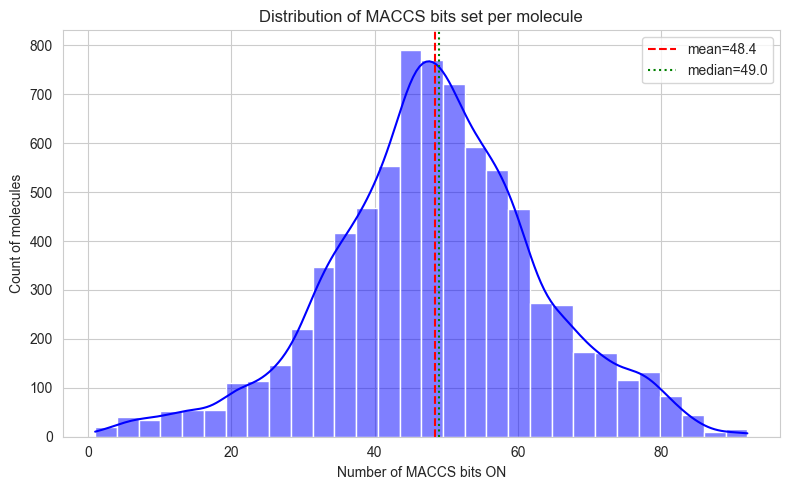

In [7]:
# Count bits set per molecule
maccs_bits_per_mol = maccs_df.sum(axis=1)

# Plot
plt.figure(figsize=(8,5))
sns.histplot(maccs_bits_per_mol, bins=30, kde=True, color='blue')
mean_val = maccs_bits_per_mol.mean()
median_val = maccs_bits_per_mol.median()
plt.axvline(mean_val, color='red', linestyle='--', label=f"mean={mean_val:.1f}")
plt.axvline(median_val, color='green', linestyle=':', label=f"median={median_val:.1f}")
plt.xlabel('Number of MACCS bits ON')
plt.ylabel('Count of molecules')
plt.title('Distribution of MACCS bits set per molecule')
plt.legend()
plt.tight_layout()
plt.savefig('../figures/maccs_bit_count_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

Hence, on average 48-50 bits out of 166 bits are turned on in maccs fingerprints of molecules in dataset.

In [30]:
### 3.3 Morgan Fingerprints
def calculate_morgan_fingerprints(smiles, generator):
    """Calculate Morgan (circular) fingerprints"""
    mol = Chem.MolFromSmiles(smiles)
    
    if mol is None:
        return None
    morgan = generator.GetFingerprint(mol)
    return np.array(morgan)


morgan_list = []
gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=512)
for idx in valid_indices:
    smiles = df.iloc[idx]['SMILES']
    morgan = calculate_morgan_fingerprints(smiles,gen)
    if morgan is not None:
        morgan_list.append(morgan)

morgan_df = pd.DataFrame(morgan_list, columns=[f'Morgan_{i}' for i in range(len(morgan_list[0]))])
print(f"Morgan fingerprints shape: {morgan_df.shape}")

Morgan fingerprints shape: (7805, 512)


Here, I experimented with fingerprint sizes of 256,512 and 2048. Fingerprint size of 512 seems to give best results as it is not too sparse(like 2048 size fingerprint) and can carry more information(less collisions, like 256 size fingerprint).

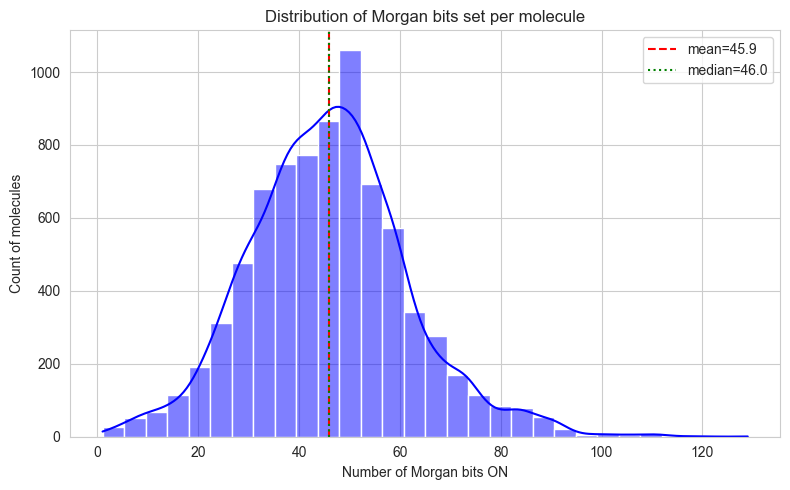

In [31]:
# Count bits set per molecule
morgan_bits_per_mol = morgan_df.sum(axis=1)

# Plot
plt.figure(figsize=(8,5))
sns.histplot(morgan_bits_per_mol, bins=30, kde=True, color='blue')
mean_val = morgan_bits_per_mol.mean()
median_val = morgan_bits_per_mol.median()
plt.axvline(mean_val, color='red', linestyle='--', label=f"mean={mean_val:.1f}")
plt.axvline(median_val, color='green', linestyle=':', label=f"median={median_val:.1f}")
plt.xlabel('Number of Morgan bits ON')
plt.ylabel('Count of molecules')
plt.title('Distribution of Morgan bits set per molecule')
plt.legend()
plt.tight_layout()
plt.savefig('../figures/morgan_bit_count_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

Hence, on average 44 morgan bits are turned on out of 512 bits, making morgan bits more sparse.

In [32]:
### 3.4 Combine Features and Prepare Labels
# Get labels for valid molecules
y = df.iloc[valid_indices]['BBB+/BBB-'].values

# Convert labels to binary (BBB+ = 1, BBB- = 0)
y_binary = (y == 'BBB+').astype(int)

# Create combined feature sets
X_descriptors = descriptors_df.values
X_maccs = maccs_df.values
X_morgan = morgan_df.values
X_desc_maccs = np.hstack([X_descriptors, X_maccs])
X_desc_morgan = np.hstack([X_descriptors, X_morgan])
X_all = np.hstack([X_descriptors, X_maccs, X_morgan])

print(f"Feature set shapes:")
print(f"  Descriptors only: {X_descriptors.shape}")
print(f"  MACCS only: {X_maccs.shape}")
print(f"  Morgan only: {X_morgan.shape}")
print(f"  Descriptors + MACCS: {X_desc_maccs.shape}")
print(f"  Descriptors + Morgan: {X_desc_morgan.shape}")
print(f"  All features: {X_all.shape}")
print(f"\nLabels shape: {y_binary.shape}")
print(f"Class distribution: BBB+ = {np.sum(y_binary)}, BBB- = {len(y_binary) - np.sum(y_binary)}")

Feature set shapes:
  Descriptors only: (7805, 12)
  MACCS only: (7805, 167)
  Morgan only: (7805, 512)
  Descriptors + MACCS: (7805, 179)
  Descriptors + Morgan: (7805, 524)
  All features: (7805, 691)

Labels shape: (7805,)
Class distribution: BBB+ = 4956, BBB- = 2849


## 4. Evaluation Functions

Functions to calculate metrics and create visualizations

In [33]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Model"):
    """
    Comprehensive model evaluation with all required metrics
    """
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    
    # Class-wise precision, recall, f1
    precision_per_class = precision_score(y_test, y_pred, average=None)
    recall_per_class = recall_score(y_test, y_pred, average=None)
    f1_per_class = f1_score(y_test, y_pred, average=None)
    
    # Overall metrics
    precision_macro = precision_score(y_test, y_pred, average='macro')
    precision_weighted = precision_score(y_test, y_pred, average='weighted')
    recall_macro = recall_score(y_test, y_pred, average='macro')
    recall_weighted = recall_score(y_test, y_pred, average='weighted')
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    
    # ROC AUC
    if y_pred_proba is not None:
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        avg_precision = average_precision_score(y_test, y_pred_proba)
    else:
        roc_auc = None
        avg_precision = None
    
    print(f"  {model_name}")
    print(f"\nOverall Metrics:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"\nPrecision:")
    print(f"  BBB- (Class 0): {precision_per_class[0]:.4f}")
    print(f"  BBB+ (Class 1): {precision_per_class[1]:.4f}")
    print(f"  Macro Average: {precision_macro:.4f}")
    print(f"  Weighted Average: {precision_weighted:.4f}")
    print(f"\nRecall:")
    print(f"  BBB- (Class 0): {recall_per_class[0]:.4f}")
    print(f"  BBB+ (Class 1): {recall_per_class[1]:.4f}")
    print(f"  Macro Average: {recall_macro:.4f}")
    print(f"  Weighted Average: {recall_weighted:.4f}")
    print(f"\nF1-Score:")
    print(f"  BBB- (Class 0): {f1_per_class[0]:.4f}")
    print(f"  BBB+ (Class 1): {f1_per_class[1]:.4f}")
    print(f"  Macro Average: {f1_macro:.4f}")
    print(f"  Weighted Average: {f1_weighted:.4f}")
    
    if roc_auc is not None:
        print(f"\nROC AUC Score: {roc_auc:.4f}")
        print(f"Average Precision Score: {avg_precision:.4f}")
    
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['BBB-', 'BBB+']))
    
    # Store results
    results = {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision_class_0': precision_per_class[0],
        'precision_class_1': precision_per_class[1],
        'precision_macro': precision_macro,
        'precision_weighted': precision_weighted,
        'recall_class_0': recall_per_class[0],
        'recall_class_1': recall_per_class[1],
        'recall_macro': recall_macro,
        'recall_weighted': recall_weighted,
        'f1_class_0': f1_per_class[0],
        'f1_class_1': f1_per_class[1],
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'roc_auc': roc_auc,
        'avg_precision': avg_precision,
        'y_test': y_test,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    return results


In [34]:
def plot_roc_curve(results_list, title="ROC Curves"):
    """
    Plot ROC curves for multiple models
    """
    plt.figure(figsize=(10, 8))
    
    for results in results_list:
        if results['y_pred_proba'] is not None:
            fpr, tpr, _ = roc_curve(results['y_test'], results['y_pred_proba'])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f"{results['model_name']} (AUC = {roc_auc:.3f})")
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_precision_recall_curve(results_list, title="Precision-Recall Curves"):
    """
    Plot Precision-Recall curves for multiple models
    """
    plt.figure(figsize=(10, 8))
    
    for results in results_list:
        if results['y_pred_proba'] is not None:
            precision, recall, _ = precision_recall_curve(results['y_test'], results['y_pred_proba'])
            avg_precision = average_precision_score(results['y_test'], results['y_pred_proba'])
            plt.plot(recall, precision, lw=2, label=f"{results['model_name']} (AP = {avg_precision:.3f})")
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(loc="best", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_test, y_pred, model_name="Model"):
    """
    Plot confusion matrix
    """
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['BBB-', 'BBB+'], 
                yticklabels=['BBB-', 'BBB+'])
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()


## 5. Train-Test Split

Split data into training and testing sets (80-20 split)

Here, we are doing stratified sampling.

In [35]:
# We'll store results for all experiments
all_results = []

# Set random seed for reproducibility
RANDOM_STATE = 42

splits = {}

for name, X in [('descriptors', X_descriptors), 
                ('maccs', X_maccs), 
                ('morgan', X_morgan),
                ('desc_maccs', X_desc_maccs),
                ('desc_morgan', X_desc_morgan),
                ('all', X_all)]:
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_binary, test_size=0.2, random_state=RANDOM_STATE, stratify=y_binary
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    splits[name] = {
        'X_train': X_train_scaled,
        'X_test': X_test_scaled,
        'y_train': y_train,
        'y_test': y_test,
        'scaler': scaler
    }
    
    print(f"{name}: Train={X_train.shape}, Test={X_test.shape}")


descriptors: Train=(6244, 12), Test=(1561, 12)
maccs: Train=(6244, 167), Test=(1561, 167)
morgan: Train=(6244, 512), Test=(1561, 512)
desc_maccs: Train=(6244, 179), Test=(1561, 179)
desc_morgan: Train=(6244, 524), Test=(1561, 524)
all: Train=(6244, 691), Test=(1561, 691)


## 6. Logistic Regression Experiments

### 6.1 Without Class Imbalance Handling

Testing with different feature representations

In [36]:
# Logistic Regression without class imbalance handling
lr_results_no_balance = []

for feature_name in ['descriptors', 'maccs', 'morgan', 'desc_maccs','desc_morgan', 'all']:
    split = splits[feature_name]
    
    lr_model = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
    
    results = evaluate_model(
        lr_model,
        split['X_train'], split['X_test'],
        split['y_train'], split['y_test'],
        model_name=f"LR - {feature_name} (No Balance)"
    )
    
    lr_results_no_balance.append(results)
    all_results.append(results)

  LR - descriptors (No Balance)

Overall Metrics:
  Accuracy: 0.8072

Precision:
  BBB- (Class 0): 0.8064
  BBB+ (Class 1): 0.8075
  Macro Average: 0.8069
  Weighted Average: 0.8071

Recall:
  BBB- (Class 0): 0.6211
  BBB+ (Class 1): 0.9142
  Macro Average: 0.7676
  Weighted Average: 0.8072

F1-Score:
  BBB- (Class 0): 0.7017
  BBB+ (Class 1): 0.8575
  Macro Average: 0.7796
  Weighted Average: 0.8006

ROC AUC Score: 0.8348
Average Precision Score: 0.8538

Classification Report:
              precision    recall  f1-score   support

        BBB-       0.81      0.62      0.70       570
        BBB+       0.81      0.91      0.86       991

    accuracy                           0.81      1561
   macro avg       0.81      0.77      0.78      1561
weighted avg       0.81      0.81      0.80      1561

  LR - maccs (No Balance)

Overall Metrics:
  Accuracy: 0.8379

Precision:
  BBB- (Class 0): 0.8126
  BBB+ (Class 1): 0.8501
  Macro Average: 0.8314
  Weighted Average: 0.8364

Recall:
  BBB

### Some Observations : 

- Due to class imbalance towards positive samples in dataset, performance on BBB- is generally worse than for BBB+, with recall being affected more.Example , for logistic regression model using just descriptors, classification report is as follows : 


    Classification Report:


                precision    recall  f1-score   support

            BBB-       0.81      0.62      0.70       570
            BBB+       0.81      0.91      0.86       991


    Notice, how even though precision for both classes are similar, recall is way worse for BBB- than BBB+.

- Using descriptors along with fingerprints leads to some improvement in AUC score eg. morgan (AUC = 0.913) vs desc + morgan (AUC = 0.920)

- Morgan fingerprints generally seem to perform better than maccs fingerprint - this could be because they are longer and more flexible (fixed substructures vs any substructure).

- Concatenation of all input representations (descriptors + morgan fp + maccs fp) seems to perform best. (AUC = 0.928)

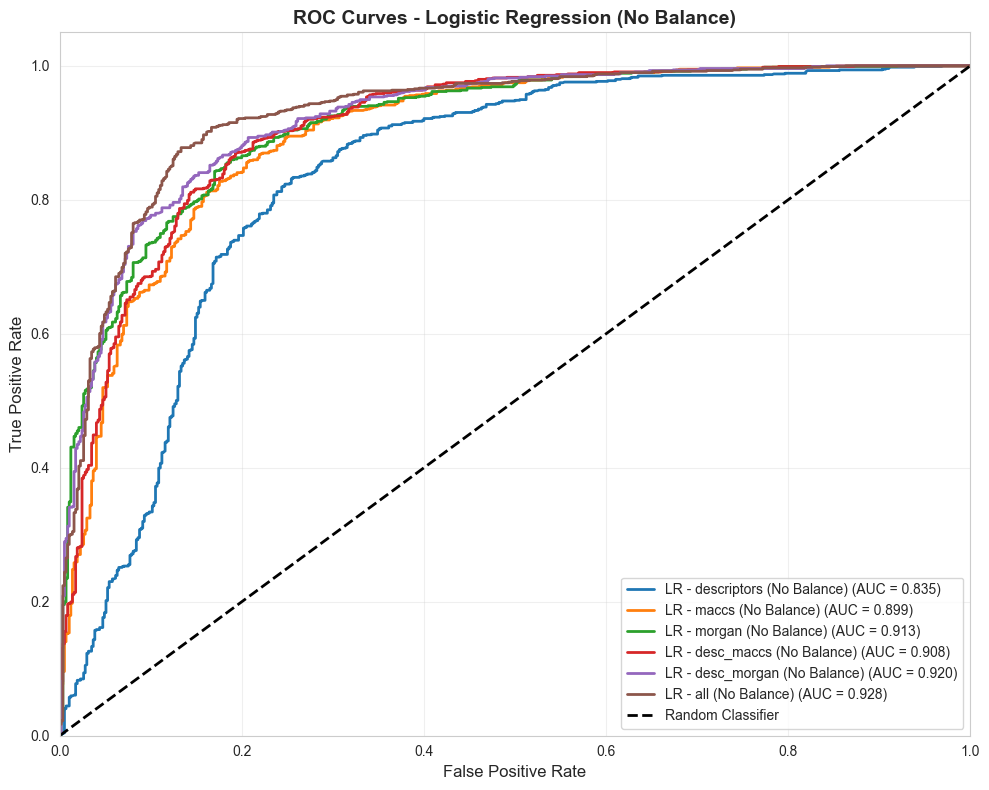

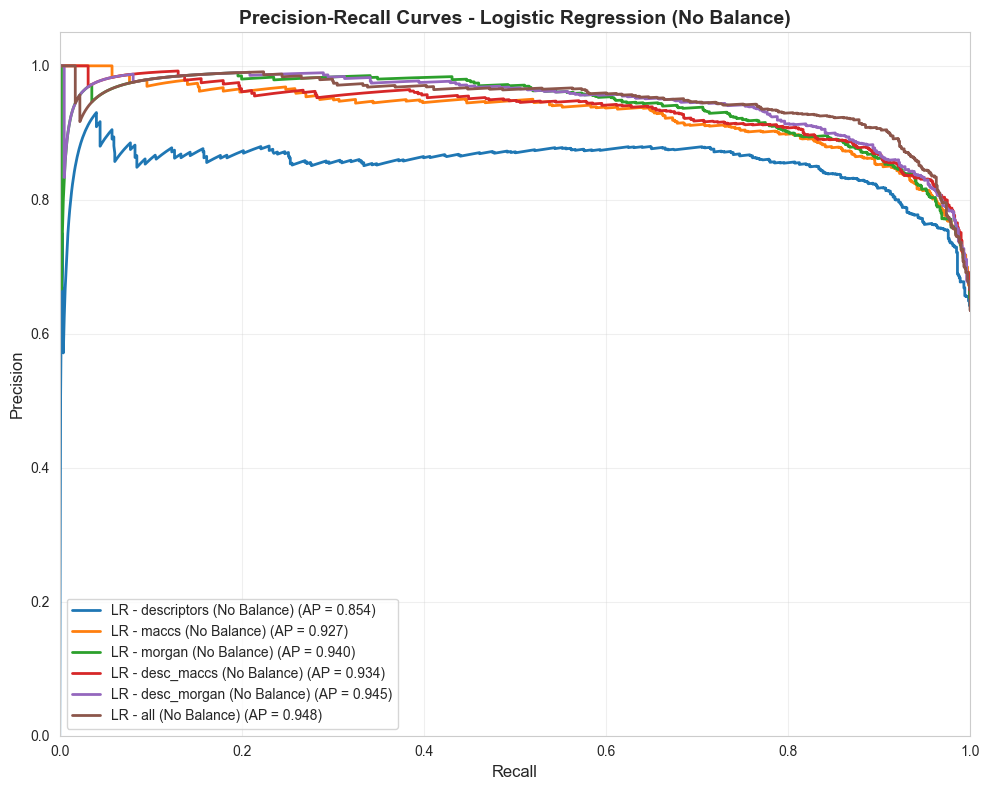

In [37]:
# Plot ROC and PR curves for LR without balance
plot_roc_curve(lr_results_no_balance, title="ROC Curves - Logistic Regression (No Balance)")
plot_precision_recall_curve(lr_results_no_balance, title="Precision-Recall Curves - Logistic Regression (No Balance)")

### 6.2 With Class Imbalance Handling (SMOTE)

Using SMOTE to balance the training data

In [38]:
# Logistic Regression with SMOTE
lr_results_smote = []

for feature_name in ['descriptors', 'maccs', 'morgan', 'desc_morgan','desc_maccs', 'all']:
    split = splits[feature_name]
    
    # Apply SMOTE to training data
    smote = SMOTE(random_state=RANDOM_STATE)
    X_train_balanced, y_train_balanced = smote.fit_resample(split['X_train'], split['y_train'])
    
    print(f"\n{feature_name}: Original train size: {len(split['y_train'])}, Balanced: {len(y_train_balanced)}")
    print(f"Class distribution after SMOTE: {np.bincount(y_train_balanced)}")
    
    lr_model = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
    lr_model.fit(X_train_balanced, y_train_balanced)
    
    y_pred = lr_model.predict(split['X_test'])
    y_pred_proba = lr_model.predict_proba(split['X_test'])[:, 1]
    
    results = evaluate_model(
        lr_model,
        X_train_balanced, split['X_test'],
        y_train_balanced, split['y_test'],
        model_name=f"LR - {feature_name} (SMOTE)"
    )
    
    lr_results_smote.append(results)
    all_results.append(results)


descriptors: Original train size: 6244, Balanced: 7930
Class distribution after SMOTE: [3965 3965]
  LR - descriptors (SMOTE)

Overall Metrics:
  Accuracy: 0.7995

Precision:
  BBB- (Class 0): 0.7189
  BBB+ (Class 1): 0.8480
  Macro Average: 0.7835
  Weighted Average: 0.8009

Recall:
  BBB- (Class 0): 0.7404
  BBB+ (Class 1): 0.8335
  Macro Average: 0.7869
  Weighted Average: 0.7995

F1-Score:
  BBB- (Class 0): 0.7295
  BBB+ (Class 1): 0.8407
  Macro Average: 0.7851
  Weighted Average: 0.8001

ROC AUC Score: 0.8365
Average Precision Score: 0.8595

Classification Report:
              precision    recall  f1-score   support

        BBB-       0.72      0.74      0.73       570
        BBB+       0.85      0.83      0.84       991

    accuracy                           0.80      1561
   macro avg       0.78      0.79      0.79      1561
weighted avg       0.80      0.80      0.80      1561


maccs: Original train size: 6244, Balanced: 7930
Class distribution after SMOTE: [3965 3965]
 

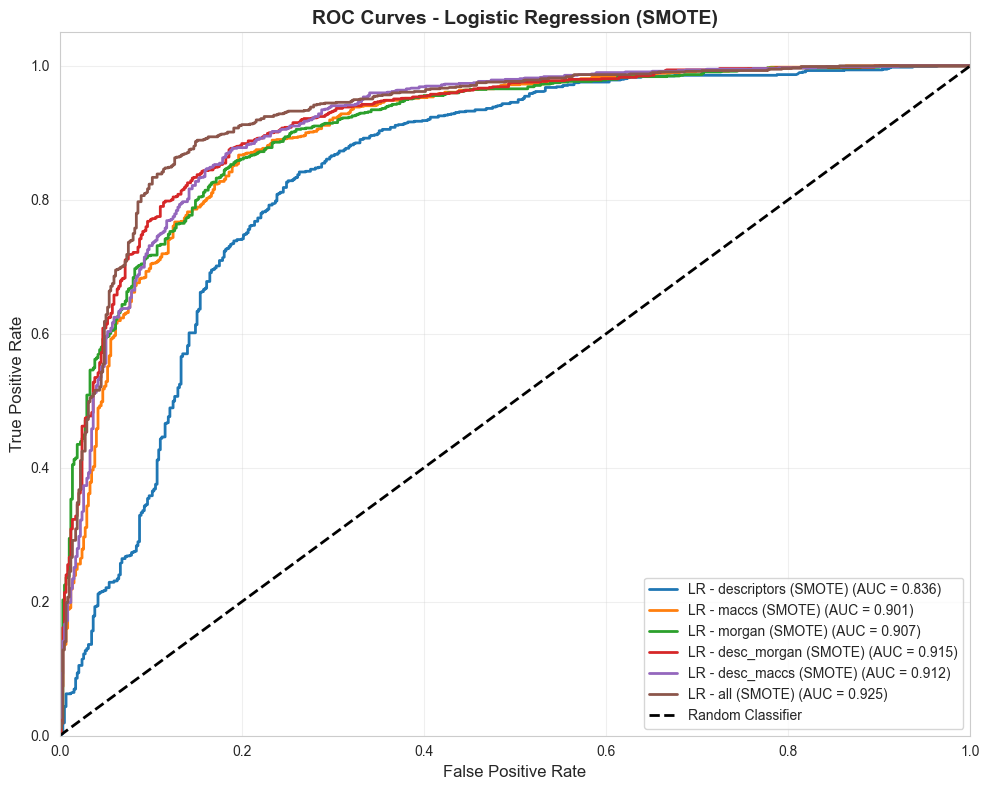

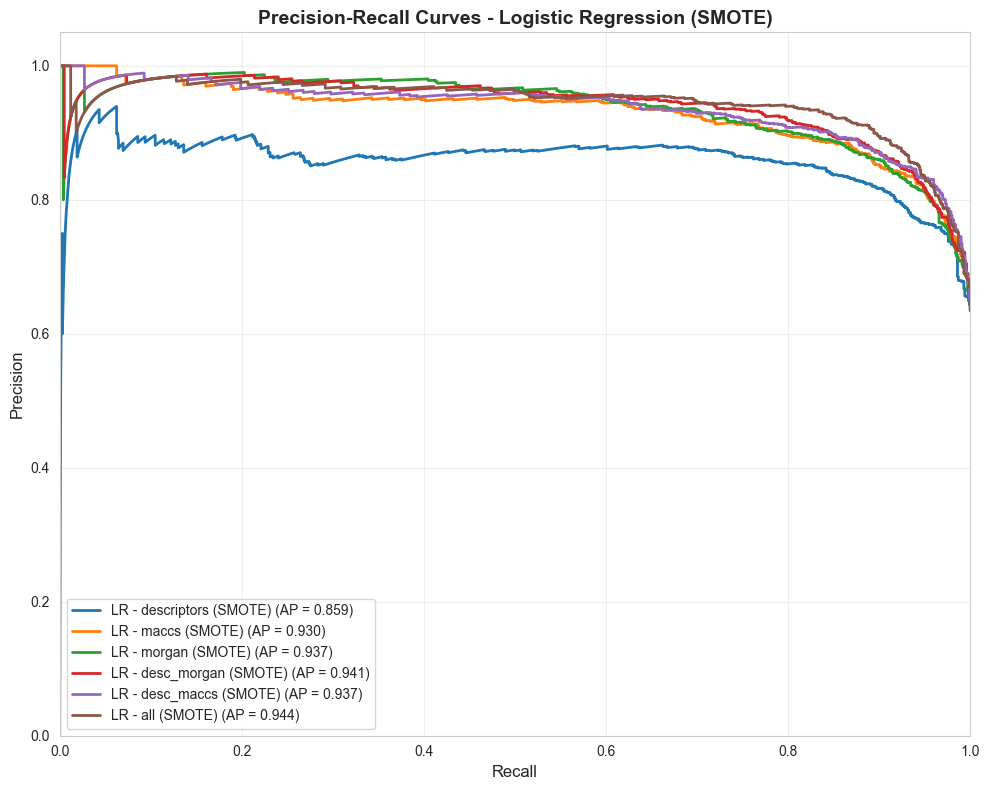

In [39]:
# Plot ROC and PR curves for LR with SMOTE
plot_roc_curve(lr_results_smote, title="ROC Curves - Logistic Regression (SMOTE)")
plot_precision_recall_curve(lr_results_smote, title="Precision-Recall Curves - Logistic Regression (SMOTE)")

### Effects of SMOTE : 
- SMOTE doesn't help performance much , even though dataset is balanced now.
- SMOTE improves recall of BBB- class, but doesn't improve accuracy and AUC overall as precision of BBB- class decreases due to SMOTE. 
- This can be explained by the fact that SMOTE doesn't work very well with high dimensional,sparse data [like our fingerprints].

### 6.4 Logistic Regression with Class Weighting

Using class_weight='balanced' (and explicit computed class weights) to handle imbalance without resampling. We'll train and evaluate Logistic Regression across the same feature sets and compare ROC / PR curves.


descriptors class weights: {0: np.float64(1.3698990785432208), 1: np.float64(0.7873896595208071)}
  LR - descriptors (ClassWeight)

Overall Metrics:
  Accuracy: 0.7976

Precision:
  BBB- (Class 0): 0.7153
  BBB+ (Class 1): 0.8476
  Macro Average: 0.7814
  Weighted Average: 0.7993

Recall:
  BBB- (Class 0): 0.7404
  BBB+ (Class 1): 0.8305
  Macro Average: 0.7854
  Weighted Average: 0.7976

F1-Score:
  BBB- (Class 0): 0.7276
  BBB+ (Class 1): 0.8389
  Macro Average: 0.7833
  Weighted Average: 0.7983

ROC AUC Score: 0.8361
Average Precision Score: 0.8578

Classification Report:
              precision    recall  f1-score   support

        BBB-       0.72      0.74      0.73       570
        BBB+       0.85      0.83      0.84       991

    accuracy                           0.80      1561
   macro avg       0.78      0.79      0.78      1561
weighted avg       0.80      0.80      0.80      1561


maccs class weights: {0: np.float64(1.3698990785432208), 1: np.float64(0.7873896595208071

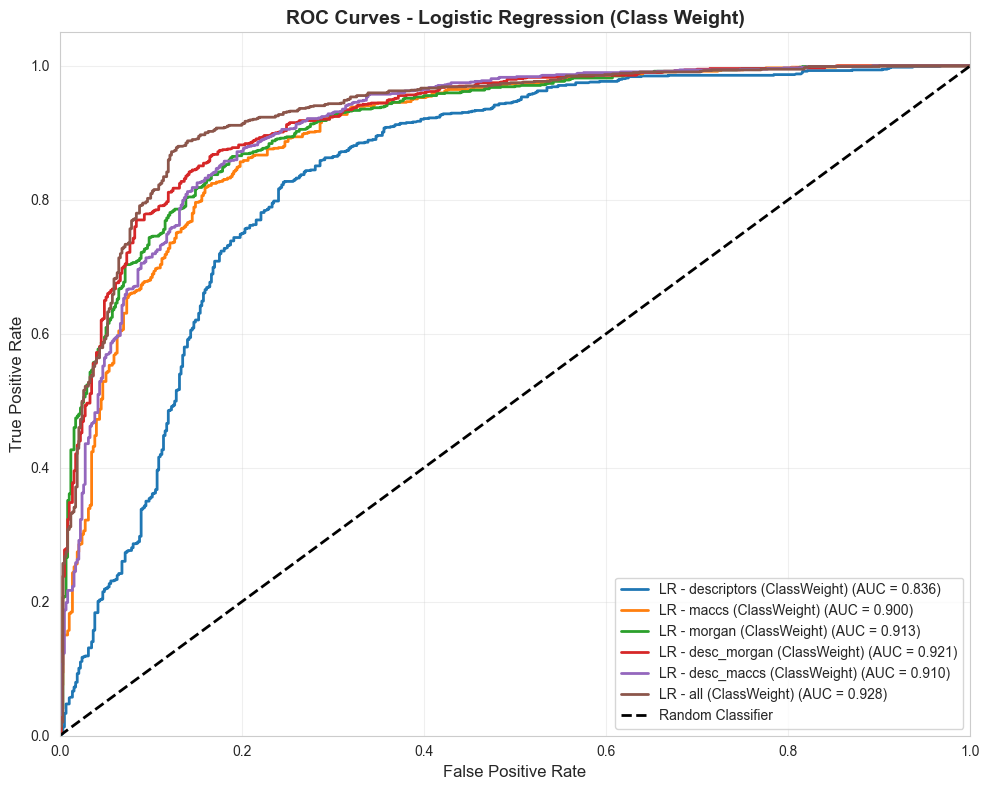

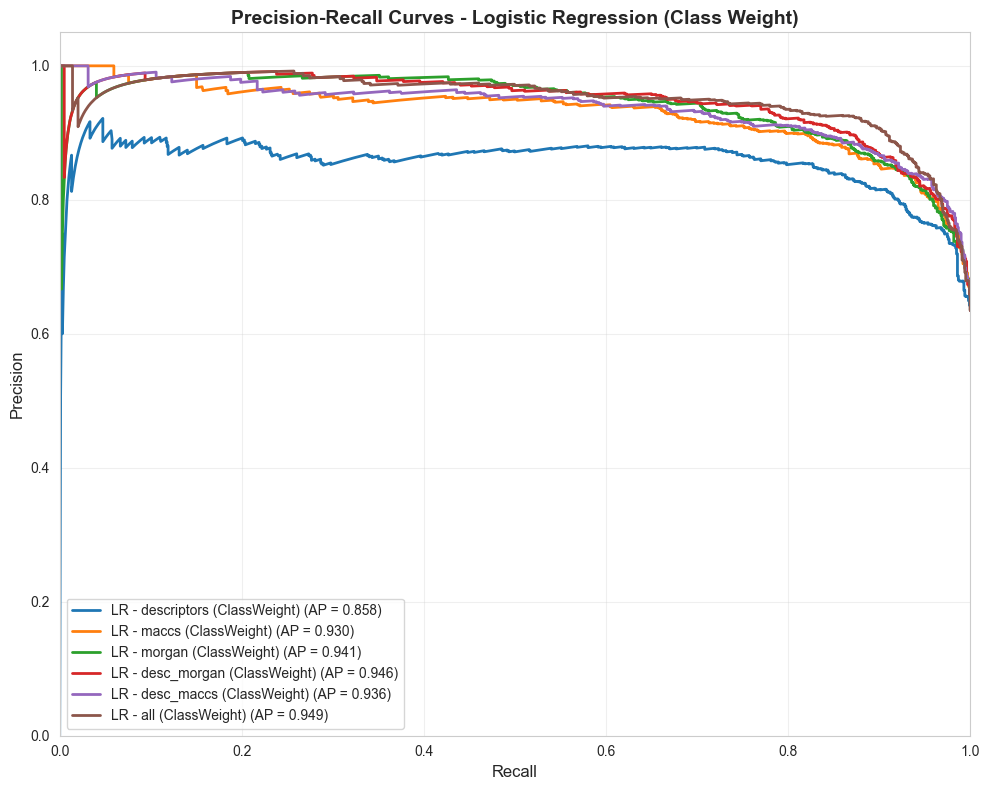

In [40]:
# Logistic Regression with class weighting
from sklearn.utils.class_weight import compute_class_weight

lr_results_class_weight = []

for feature_name in ['descriptors', 'maccs', 'morgan', 'desc_morgan','desc_maccs', 'all']:
    split = splits[feature_name]
    
    # Compute class weights from training data
    classes = np.unique(split['y_train'])
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=split['y_train'])
    cw = {int(c): w for c, w in zip(classes, class_weights)}
    print(f"\n{feature_name} class weights: {cw}")
    
    # Train Logistic Regression with class_weight
    lr_model_cw = LogisticRegression(max_iter=1000, class_weight=cw, random_state=RANDOM_STATE)
    
    results = evaluate_model(
        lr_model_cw,
        split['X_train'], split['X_test'],
        split['y_train'], split['y_test'],
        model_name=f"LR - {feature_name} (ClassWeight)"
    )
    
    lr_results_class_weight.append(results)
    all_results.append(results)

# Plot ROC and PR curves for class-weighted LR
plot_roc_curve(lr_results_class_weight, title="ROC Curves - Logistic Regression (Class Weight)")
plot_precision_recall_curve(lr_results_class_weight, title="Precision-Recall Curves - Logistic Regression (Class Weight)")

Similarly, we seee that weighting classes differently mostly leads to similar AUC.

This is because even though recall of minority class (BBB-) increases because of class weighting, precision of minority class(BBB-) decreases [as more molecules get classified as BBB-].

Hence , overall performance stays similar. [just like SMOTE]

### 6.3 Logistic Regression with PCA

Using PCA to reduce dimensionality and identify most important features

In [43]:
# Apply PCA to find optimal number of components (explaining 95% variance)
lr_results_pca = []

for feature_name in ['descriptors', 'maccs', 'morgan','desc_morgan','desc_maccs', 'all']:
    split = splits[feature_name]
    
    # Apply PCA with 95% variance explained
    pca = PCA(n_components=0.95, random_state=RANDOM_STATE)
    X_train_pca = pca.fit_transform(split['X_train'])
    X_test_pca = pca.transform(split['X_test'])
    
    print(f"\n{feature_name}:")
    print(f"  Original dimensions: {split['X_train'].shape[1]}")
    print(f"  PCA components (95% variance): {X_train_pca.shape[1]}")
    print(f"  Explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}")
    
    # Train Logistic Regression on PCA features
    lr_model = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
    
    results = evaluate_model(
        lr_model,
        X_train_pca, X_test_pca,
        split['y_train'], split['y_test'],
        model_name=f"LR - {feature_name} (PCA 95%)"
    )
    
    lr_results_pca.append(results)
    all_results.append(results)


descriptors:
  Original dimensions: 12
  PCA components (95% variance): 6
  Explained variance ratio: 0.9609
  LR - descriptors (PCA 95%)

Overall Metrics:
  Accuracy: 0.7976

Precision:
  BBB- (Class 0): 0.8098
  BBB+ (Class 1): 0.7932
  Macro Average: 0.8015
  Weighted Average: 0.7993

Recall:
  BBB- (Class 0): 0.5825
  BBB+ (Class 1): 0.9213
  Macro Average: 0.7519
  Weighted Average: 0.7976

F1-Score:
  BBB- (Class 0): 0.6776
  BBB+ (Class 1): 0.8525
  Macro Average: 0.7650
  Weighted Average: 0.7886

ROC AUC Score: 0.8226
Average Precision Score: 0.8227

Classification Report:
              precision    recall  f1-score   support

        BBB-       0.81      0.58      0.68       570
        BBB+       0.79      0.92      0.85       991

    accuracy                           0.80      1561
   macro avg       0.80      0.75      0.77      1561
weighted avg       0.80      0.80      0.79      1561


maccs:
  Original dimensions: 167
  PCA components (95% variance): 89
  Explained 

  LR - maccs (PCA 95%)

Overall Metrics:
  Accuracy: 0.8341

Precision:
  BBB- (Class 0): 0.8206
  BBB+ (Class 1): 0.8401
  Macro Average: 0.8304
  Weighted Average: 0.8330

Recall:
  BBB- (Class 0): 0.6982
  BBB+ (Class 1): 0.9122
  Macro Average: 0.8052
  Weighted Average: 0.8341

F1-Score:
  BBB- (Class 0): 0.7545
  BBB+ (Class 1): 0.8747
  Macro Average: 0.8146
  Weighted Average: 0.8308

ROC AUC Score: 0.8883
Average Precision Score: 0.9223

Classification Report:
              precision    recall  f1-score   support

        BBB-       0.82      0.70      0.75       570
        BBB+       0.84      0.91      0.87       991

    accuracy                           0.83      1561
   macro avg       0.83      0.81      0.81      1561
weighted avg       0.83      0.83      0.83      1561


morgan:
  Original dimensions: 512
  PCA components (95% variance): 387
  Explained variance ratio: 0.9504
  LR - morgan (PCA 95%)

Overall Metrics:
  Accuracy: 0.8456

Precision:
  BBB- (Class 0): 

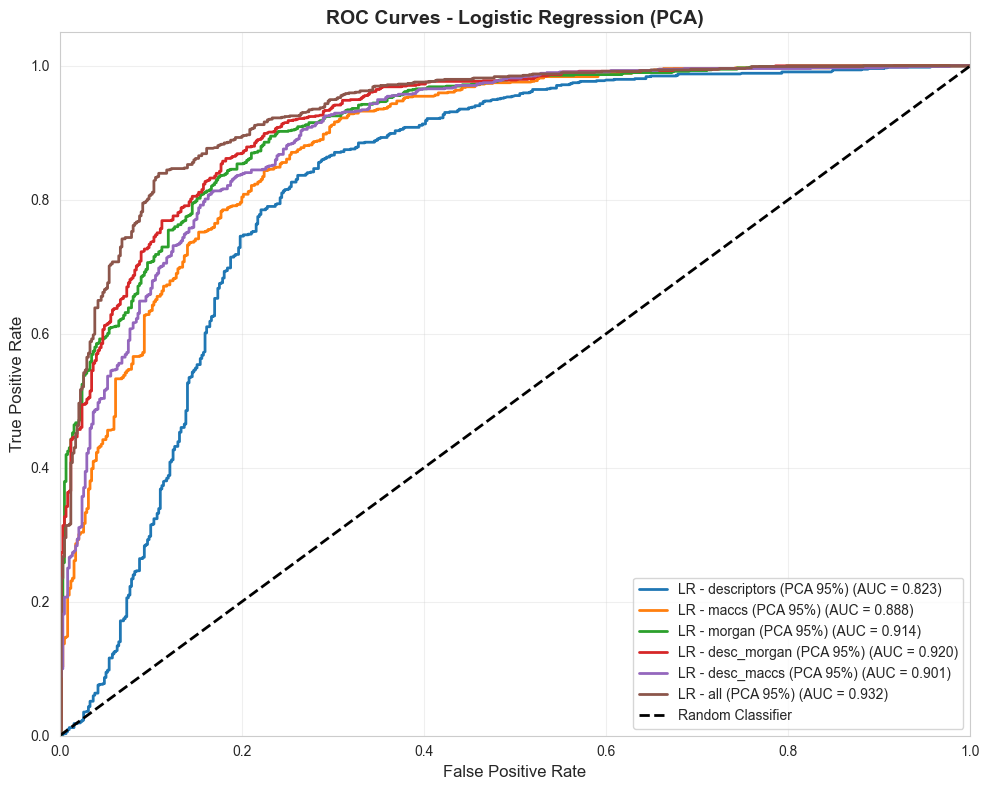

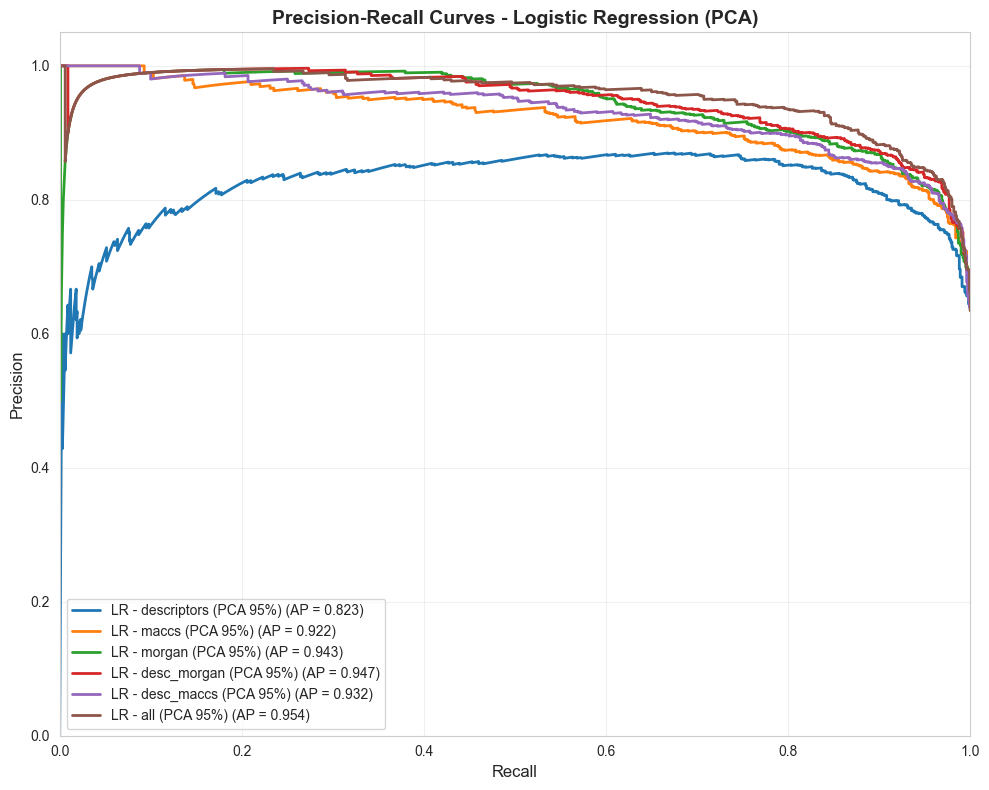

In [44]:
# Plot ROC and PR curves for LR with PCA
plot_roc_curve(lr_results_pca, title="ROC Curves - Logistic Regression (PCA)")
plot_precision_recall_curve(lr_results_pca, title="Precision-Recall Curves - Logistic Regression (PCA)")

### Some observations

- Using PCA leads to lower AUC for descriptors,maccs and desc_maccs. This could be because they are relatively low dimensional representations, and hence removing some dimensions leads to loss of information which leads to worst performance.

- However, it improves(or doesn't affect) performance for morgan,desc_morgan and all(morgan + maccs + descriptors). This could be because morgan fingerprints are comparatively high dimensional and sparse, and hence removing some of the extraneous dimensions helped improve performance of classifier.

## Best Model for Logistic Regression

**AUC = 0.932**

Input = Principal components explaining 95% variance after performing PCA on [morgan + maccs + descriptors]

## 7. Random Forest Experiments

### 7.1 Random Forest with Default Parameters (No Balance)

In [45]:
# Random Forest without class imbalance handling
rf_results_no_balance = []

for feature_name in ['descriptors', 'maccs', 'morgan', 'desc_morgan','desc_maccs', 'all']:
    split = splits[feature_name]
    
    # Create and train model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
    
    results = evaluate_model(
        rf_model,
        split['X_train'], split['X_test'],
        split['y_train'], split['y_test'],
        model_name=f"RF - {feature_name} (No Balance)"
    )
    
    rf_results_no_balance.append(results)
    all_results.append(results)

  RF - descriptors (No Balance)

Overall Metrics:
  Accuracy: 0.8757

Precision:
  BBB- (Class 0): 0.8615
  BBB+ (Class 1): 0.8828
  Macro Average: 0.8722
  Weighted Average: 0.8750

Recall:
  BBB- (Class 0): 0.7860
  BBB+ (Class 1): 0.9273
  Macro Average: 0.8567
  Weighted Average: 0.8757

F1-Score:
  BBB- (Class 0): 0.8220
  BBB+ (Class 1): 0.9045
  Macro Average: 0.8633
  Weighted Average: 0.8744

ROC AUC Score: 0.9512
Average Precision Score: 0.9693

Classification Report:
              precision    recall  f1-score   support

        BBB-       0.86      0.79      0.82       570
        BBB+       0.88      0.93      0.90       991

    accuracy                           0.88      1561
   macro avg       0.87      0.86      0.86      1561
weighted avg       0.88      0.88      0.87      1561

  RF - maccs (No Balance)

Overall Metrics:
  Accuracy: 0.8943

Precision:
  BBB- (Class 0): 0.8872
  BBB+ (Class 1): 0.8979
  Macro Average: 0.8925
  Weighted Average: 0.8940

Recall:
  BBB

Clearly, random forests perform far better on this task than logistic regression as we achieve AUC scores in range 0.95 - 0.96, which is better than best AUC score of logistic regression of 0.932.

MACCS fingerprints seem to perform slightly better than morgan fingerprints. This could be because of fixed meaning of bits in MACCS while same bit in morgan could refer to two different substructures due to hashing collisions.

### 7.2 Random Forest with SMOTE

In [46]:
# Random Forest with SMOTE
rf_results_smote = []

for feature_name in ['descriptors', 'maccs', 'morgan', 'desc_morgan','desc_maccs', 'all']:
    split = splits[feature_name]
    
    # Apply SMOTE to training data
    smote = SMOTE(random_state=RANDOM_STATE)
    X_train_balanced, y_train_balanced = smote.fit_resample(split['X_train'], split['y_train'])
    
    # Create and train model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
    rf_model.fit(X_train_balanced, y_train_balanced)
    
    results = evaluate_model(
        rf_model,
        X_train_balanced, split['X_test'],
        y_train_balanced, split['y_test'],
        model_name=f"RF - {feature_name} (SMOTE)"
    )
    
    rf_results_smote.append(results)
    all_results.append(results)

  RF - descriptors (SMOTE)

Overall Metrics:
  Accuracy: 0.8751

Precision:
  BBB- (Class 0): 0.8391
  BBB+ (Class 1): 0.8948
  Macro Average: 0.8670
  Weighted Average: 0.8745

Recall:
  BBB- (Class 0): 0.8140
  BBB+ (Class 1): 0.9102
  Macro Average: 0.8621
  Weighted Average: 0.8751

F1-Score:
  BBB- (Class 0): 0.8264
  BBB+ (Class 1): 0.9025
  Macro Average: 0.8644
  Weighted Average: 0.8747

ROC AUC Score: 0.9513
Average Precision Score: 0.9681

Classification Report:
              precision    recall  f1-score   support

        BBB-       0.84      0.81      0.83       570
        BBB+       0.89      0.91      0.90       991

    accuracy                           0.88      1561
   macro avg       0.87      0.86      0.86      1561
weighted avg       0.87      0.88      0.87      1561

  RF - maccs (SMOTE)

Overall Metrics:
  Accuracy: 0.9013

Precision:
  BBB- (Class 0): 0.8910
  BBB+ (Class 1): 0.9067
  Macro Average: 0.8988
  Weighted Average: 0.9010

Recall:
  BBB- (Class 0

As seen in logistic regression, performance after SMOTE stays more or less the same due to precision - recall tradeoff in BBB- class.

### 7.3 Random Forest with PCA

In [47]:
# Random Forest with PCA
rf_results_pca = []

for feature_name in ['descriptors', 'maccs', 'morgan','desc_morgan','desc_maccs', 'all']:
    split = splits[feature_name]
    
    # Apply PCA
    pca = PCA(n_components=0.95, random_state=RANDOM_STATE)
    X_train_pca = pca.fit_transform(split['X_train'])
    X_test_pca = pca.transform(split['X_test'])
    
    print(f"\n{feature_name}: PCA components = {X_train_pca.shape[1]}")
    
    # Train Random Forest on PCA features
    rf_model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
    
    results = evaluate_model(
        rf_model,
        X_train_pca, X_test_pca,
        split['y_train'], split['y_test'],
        model_name=f"RF - {feature_name} (PCA 95%)"
    )
    
    rf_results_pca.append(results)
    all_results.append(results)


descriptors: PCA components = 6
  RF - descriptors (PCA 95%)

Overall Metrics:
  Accuracy: 0.8719

Precision:
  BBB- (Class 0): 0.8517
  BBB+ (Class 1): 0.8821
  Macro Average: 0.8669
  Weighted Average: 0.8710

Recall:
  BBB- (Class 0): 0.7860
  BBB+ (Class 1): 0.9213
  Macro Average: 0.8536
  Weighted Average: 0.8719

F1-Score:
  BBB- (Class 0): 0.8175
  BBB+ (Class 1): 0.9013
  Macro Average: 0.8594
  Weighted Average: 0.8707

ROC AUC Score: 0.9444
Average Precision Score: 0.9625

Classification Report:
              precision    recall  f1-score   support

        BBB-       0.85      0.79      0.82       570
        BBB+       0.88      0.92      0.90       991

    accuracy                           0.87      1561
   macro avg       0.87      0.85      0.86      1561
weighted avg       0.87      0.87      0.87      1561


maccs: PCA components = 89
  RF - maccs (PCA 95%)

Overall Metrics:
  Accuracy: 0.8917

Precision:
  BBB- (Class 0): 0.9067
  BBB+ (Class 1): 0.8848
  Macro Av

Doing PCA doesn't seem to help random forests performance, instead slightly degrading it in most cases.

This makes sense as splits in random forests are made on most informative features, and removing extraneous features doesn't help much.

### 7.4 Random Forest with Hyperparameter Tuning (RandomizedSearchCV)

Tuning on the best performing feature set

In [58]:
# Hyperparameter tuning for Random Forest
# We'll tune on the 'all' features as it is performing best.

split = splits['all']  


# Define parameter grid
param_distributions = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [10, 20, 40, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 8]
}

# Create RandomizedSearchCV
rf_random = RandomizedSearchCV(
    RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    param_distributions=param_distributions,
    n_iter=50,  # Number of parameter settings sampled
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1
)

print("Performing RandomizedSearchCV for Random Forest...")

rf_random.fit(split['X_train'], split['y_train'])

print(f"\nBest parameters found:")
print(rf_random.best_params_)
print(f"\nBest cross-validation ROC AUC score: {rf_random.best_score_:.4f}")

# Evaluate best model
best_rf = rf_random.best_estimator_
y_pred = best_rf.predict(split['X_test'])
y_pred_proba = best_rf.predict_proba(split['X_test'])[:, 1]

results_tuned = evaluate_model(
    best_rf,
    split['X_train'], split['X_test'],
    split['y_train'], split['y_test'],
    model_name="RF - all (Tuned)"
)

all_results.append(results_tuned)

Performing RandomizedSearchCV for Random Forest...
Fitting 5 folds for each of 50 candidates, totalling 250 fits



Best parameters found:
{'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None}

Best cross-validation ROC AUC score: 0.9566
  RF - all (Tuned)

Overall Metrics:
  Accuracy: 0.8975

Precision:
  BBB- (Class 0): 0.9004
  BBB+ (Class 1): 0.8961
  Macro Average: 0.8982
  Weighted Average: 0.8977

Recall:
  BBB- (Class 0): 0.8088
  BBB+ (Class 1): 0.9485
  Macro Average: 0.8787
  Weighted Average: 0.8975

F1-Score:
  BBB- (Class 0): 0.8521
  BBB+ (Class 1): 0.9216
  Macro Average: 0.8868
  Weighted Average: 0.8962

ROC AUC Score: 0.9651
Average Precision Score: 0.9779

Classification Report:
              precision    recall  f1-score   support

        BBB-       0.90      0.81      0.85       570
        BBB+       0.90      0.95      0.92       991

    accuracy                           0.90      1561
   macro avg       0.90      0.88      0.89      1561
weighted avg       0.90      0.90      0.90      1561



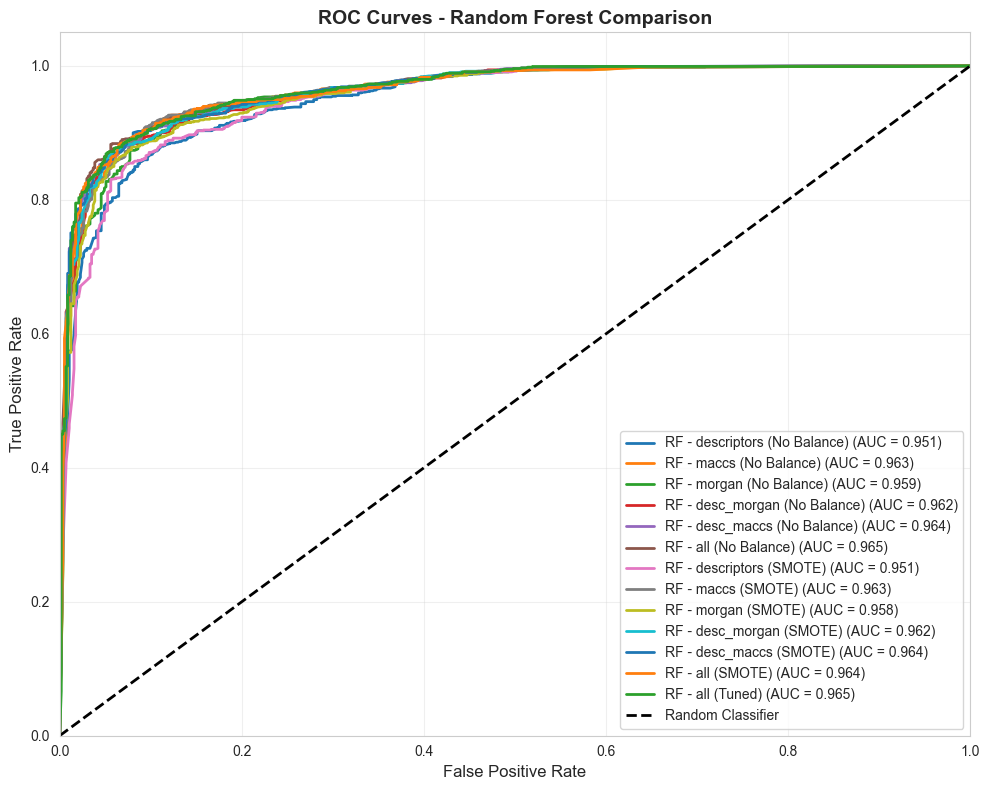

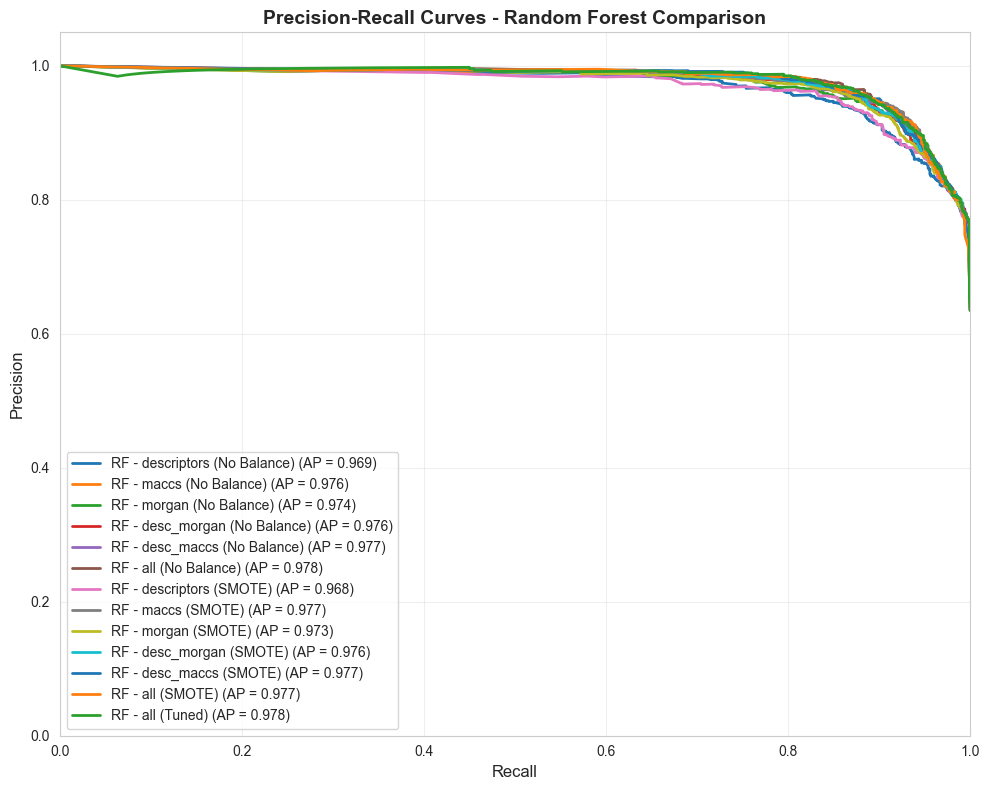

In [59]:
# Plot comparison of RF models
rf_comparison = rf_results_no_balance + rf_results_smote + [results_tuned]
plot_roc_curve(rf_comparison, title="ROC Curves - Random Forest Comparison")
plot_precision_recall_curve(rf_comparison, title="Precision-Recall Curves - Random Forest Comparison")

## Best RF Model

**AUC Score = 0.965**

Model - RF with input features [morgan + maccs + descriptors]

## 8. XGBoost Experiments

### 8.1 XGBoost with Different Feature Sets

In [60]:
# XGBoost without class imbalance handling
xgb_results_no_balance = []

for feature_name in ['descriptors', 'maccs', 'morgan', 'desc_maccs','desc_morgan', 'all']:
    split = splits[feature_name]
    
    # Create and train model
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        random_state=RANDOM_STATE,
        use_label_encoder=False,
        eval_metric='logloss',
        n_jobs=-1
    )
    
    results = evaluate_model(
        xgb_model,
        split['X_train'], split['X_test'],
        split['y_train'], split['y_test'],
        model_name=f"XGB - {feature_name} (No Balance)"
    )
    
    xgb_results_no_balance.append(results)
    all_results.append(results)

  XGB - descriptors (No Balance)

Overall Metrics:
  Accuracy: 0.8738

Precision:
  BBB- (Class 0): 0.8650
  BBB+ (Class 1): 0.8781
  Macro Average: 0.8715
  Weighted Average: 0.8733

Recall:
  BBB- (Class 0): 0.7754
  BBB+ (Class 1): 0.9304
  Macro Average: 0.8529
  Weighted Average: 0.8738

F1-Score:
  BBB- (Class 0): 0.8178
  BBB+ (Class 1): 0.9035
  Macro Average: 0.8606
  Weighted Average: 0.8722

ROC AUC Score: 0.9427
Average Precision Score: 0.9615

Classification Report:
              precision    recall  f1-score   support

        BBB-       0.86      0.78      0.82       570
        BBB+       0.88      0.93      0.90       991

    accuracy                           0.87      1561
   macro avg       0.87      0.85      0.86      1561
weighted avg       0.87      0.87      0.87      1561

  XGB - maccs (No Balance)

Overall Metrics:
  Accuracy: 0.8994

Precision:
  BBB- (Class 0): 0.8889
  BBB+ (Class 1): 0.9049
  Macro Average: 0.8969
  Weighted Average: 0.8990

Recall:
  B

Here, best performing model is one with input representation descriptors + MACCS with AUC of 0.9612

### 8.2 XGBoost with SMOTE

In [62]:
# XGBoost with SMOTE
xgb_results_smote = []

for feature_name in ['descriptors', 'maccs', 'morgan', 'desc_maccs','desc_morgan', 'all']:
    split = splits[feature_name]
    
    # Apply SMOTE to training data
    smote = SMOTE(random_state=RANDOM_STATE)
    X_train_balanced, y_train_balanced = smote.fit_resample(split['X_train'], split['y_train'])
    
    # Create and train model
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        random_state=RANDOM_STATE,
        use_label_encoder=False,
        eval_metric='logloss',
        n_jobs=-1
    )
    xgb_model.fit(X_train_balanced, y_train_balanced)
    
    results = evaluate_model(
        xgb_model,
        X_train_balanced, split['X_test'],
        y_train_balanced, split['y_test'],
        model_name=f"XGB - {feature_name} (SMOTE)"
    )
    
    xgb_results_smote.append(results)
    all_results.append(results)

  XGB - descriptors (SMOTE)

Overall Metrics:
  Accuracy: 0.8712

Precision:
  BBB- (Class 0): 0.8475
  BBB+ (Class 1): 0.8835
  Macro Average: 0.8655
  Weighted Average: 0.8703

Recall:
  BBB- (Class 0): 0.7895
  BBB+ (Class 1): 0.9183
  Macro Average: 0.8539
  Weighted Average: 0.8712

F1-Score:
  BBB- (Class 0): 0.8174
  BBB+ (Class 1): 0.9005
  Macro Average: 0.8590
  Weighted Average: 0.8702

ROC AUC Score: 0.9383
Average Precision Score: 0.9590

Classification Report:
              precision    recall  f1-score   support

        BBB-       0.85      0.79      0.82       570
        BBB+       0.88      0.92      0.90       991

    accuracy                           0.87      1561
   macro avg       0.87      0.85      0.86      1561
weighted avg       0.87      0.87      0.87      1561

  XGB - maccs (SMOTE)

Overall Metrics:
  Accuracy: 0.9039

Precision:
  BBB- (Class 0): 0.8918
  BBB+ (Class 1): 0.9102
  Macro Average: 0.9010
  Weighted Average: 0.9035

Recall:
  BBB- (Class

SMOTE doesn't improve results noticeably for any of the models (similar results to logistic regression and random forests).

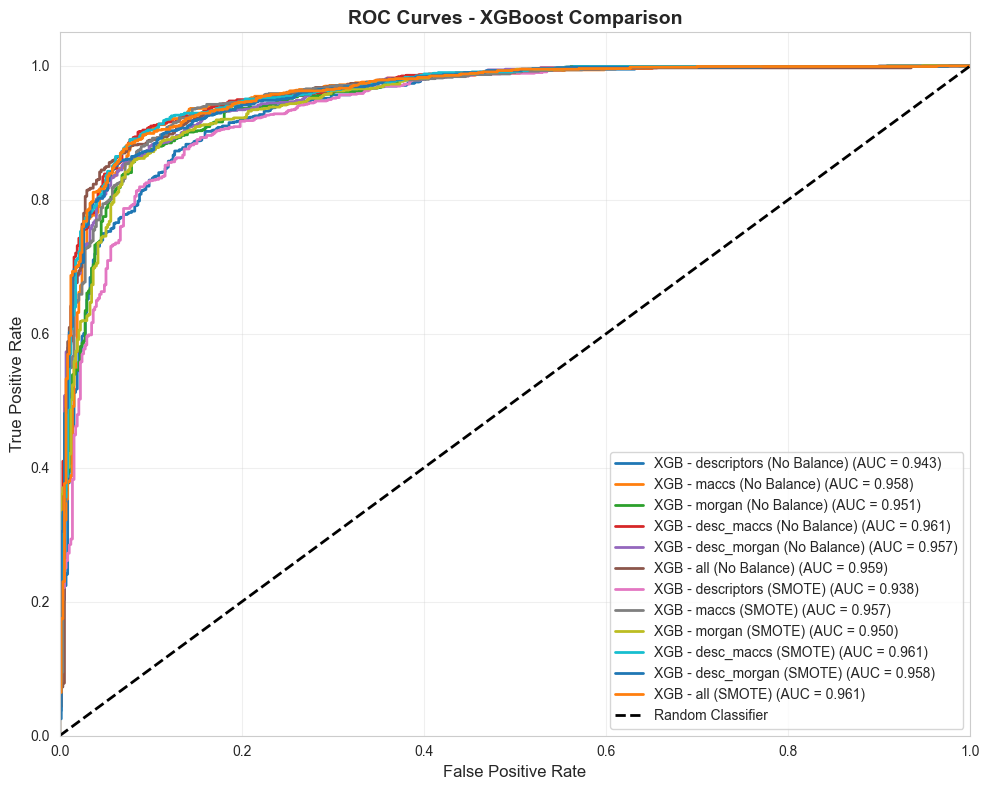

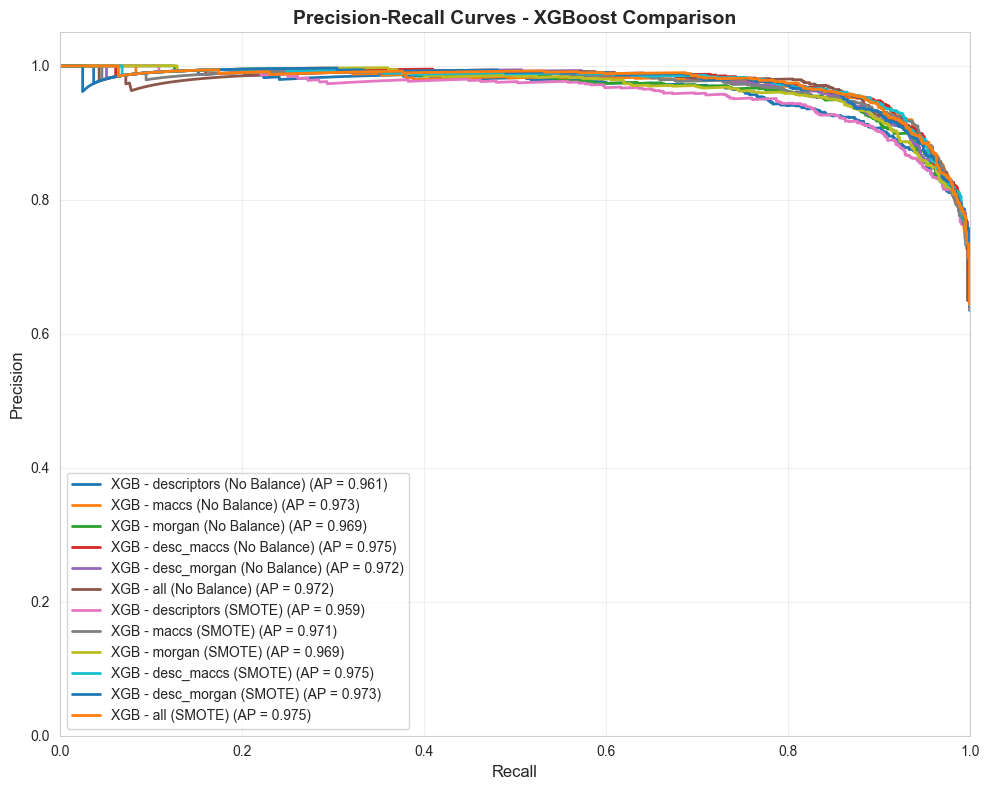

In [63]:
# Plot XGBoost comparison
xgb_comparison = xgb_results_no_balance + xgb_results_smote
plot_roc_curve(xgb_comparison, title="ROC Curves - XGBoost Comparison")
plot_precision_recall_curve(xgb_comparison, title="Precision-Recall Curves - XGBoost Comparison")

## Best XGBoost Model : 

**AUC Score = 0.961**

Model - input descirptors + MACCS

## 9. Ensemble Methods

Combining multiple models for improved performance

### 9.1 Voting Classifier (Soft Voting)

In [68]:
# Voting Classifier with best models from each type
# Using 'all' features with SMOTE

split = splits['all']

# Define base estimators
lr = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
rf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
xgb_clf = xgb.XGBClassifier(n_estimators=100, random_state=RANDOM_STATE, 
                            use_label_encoder=False, eval_metric='logloss', n_jobs=-1)

# Create voting classifier
voting_clf = VotingClassifier(
    estimators=[('lr', lr), ('rf', rf), ('xgb', xgb_clf)],
    voting='soft'
)

print("Training Voting Classifier...")
results_voting = evaluate_model(
    voting_clf,
    split['X_train'], split['X_test'],
    split['y_train'], split['y_test'],
    model_name="Voting Ensemble (LR+RF+XGB, imbalanced)"
)

all_results.append(results_voting)

Training Voting Classifier...


  Voting Ensemble (LR+RF+XGB, imbalanced)

Overall Metrics:
  Accuracy: 0.8911

Precision:
  BBB- (Class 0): 0.8876
  BBB+ (Class 1): 0.8928
  Macro Average: 0.8902
  Weighted Average: 0.8909

Recall:
  BBB- (Class 0): 0.8035
  BBB+ (Class 1): 0.9415
  Macro Average: 0.8725
  Weighted Average: 0.8911

F1-Score:
  BBB- (Class 0): 0.8435
  BBB+ (Class 1): 0.9165
  Macro Average: 0.8800
  Weighted Average: 0.8898

ROC AUC Score: 0.9643
Average Precision Score: 0.9770

Classification Report:
              precision    recall  f1-score   support

        BBB-       0.89      0.80      0.84       570
        BBB+       0.89      0.94      0.92       991

    accuracy                           0.89      1561
   macro avg       0.89      0.87      0.88      1561
weighted avg       0.89      0.89      0.89      1561



AUC Score of (Soft)Voting Classifier = 0.9643

### 9.2 Stacking Classifier

In [69]:
# Stacking Classifier
# Base models: LR, RF, XGB
# Meta-model: Logistic Regression

base_estimators = [
    ('lr', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)),
    ('xgb', xgb.XGBClassifier(n_estimators=100, random_state=RANDOM_STATE, 
                              use_label_encoder=False, eval_metric='logloss', n_jobs=-1))
]

stacking_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5
)

print("Training Stacking Classifier...")
results_stacking = evaluate_model(
    stacking_clf,
    split['X_train'], split['X_test'],
    split['y_train'], split['y_test'],
    model_name="Stacking Ensemble (LR+RF+XGB, imbalanced)"
)

all_results.append(results_stacking)

Training Stacking Classifier...
  Stacking Ensemble (LR+RF+XGB, imbalanced)

Overall Metrics:
  Accuracy: 0.8988

Precision:
  BBB- (Class 0): 0.8858
  BBB+ (Class 1): 0.9056
  Macro Average: 0.8957
  Weighted Average: 0.8983

Recall:
  BBB- (Class 0): 0.8298
  BBB+ (Class 1): 0.9384
  Macro Average: 0.8841
  Weighted Average: 0.8988

F1-Score:
  BBB- (Class 0): 0.8569
  BBB+ (Class 1): 0.9217
  Macro Average: 0.8893
  Weighted Average: 0.8980

ROC AUC Score: 0.9663
Average Precision Score: 0.9783

Classification Report:
              precision    recall  f1-score   support

        BBB-       0.89      0.83      0.86       570
        BBB+       0.91      0.94      0.92       991

    accuracy                           0.90      1561
   macro avg       0.90      0.88      0.89      1561
weighted avg       0.90      0.90      0.90      1561



**AUC Score of Meta-Model = 0.9661**
This is best AUC achieved so far.

## 10. Final Comparison

### 10.1 Compare All Models

In [66]:
comparison_df = pd.DataFrame([
    {
        'Model': r['model_name'],
        'Accuracy': r['accuracy'],
        'Precision (BBB-)': r['precision_class_0'],
        'Precision (BBB+)': r['precision_class_1'],
        'Recall (BBB-)': r['recall_class_0'],
        'Recall (BBB+)': r['recall_class_1'],
        'F1 (BBB-)': r['f1_class_0'],
        'F1 (BBB+)': r['f1_class_1'],
        'F1 Macro': r['f1_macro'],
        'ROC AUC': r['roc_auc'] if r['roc_auc'] else 0
    }
    for r in all_results
])

comparison_df = comparison_df.sort_values('ROC AUC', ascending=False)

print("FINAL COMPARISON OF ALL MODELS")

print(comparison_df.to_string(index=False))

comparison_df.to_csv('../figures/model_comparison.csv', index=False)

FINAL COMPARISON OF ALL MODELS
                               Model  Accuracy  Precision (BBB-)  Precision (BBB+)  Recall (BBB-)  Recall (BBB+)  F1 (BBB-)  F1 (BBB+)  F1 Macro  ROC AUC
Stacking Ensemble (LR+RF+XGB, SMOTE)  0.903267          0.876122          0.918327       0.856140       0.930373   0.866016   0.924311  0.895163 0.966055
                    RF - all (Tuned)  0.897502          0.900391          0.896092       0.808772       0.948537   0.852126   0.921569  0.886847 0.965111
             RF - desc_maccs (Tuned)  0.897502          0.900391          0.896092       0.808772       0.948537   0.852126   0.921569  0.886847 0.965111
                    RF - all (Tuned)  0.897502          0.900391          0.896092       0.808772       0.948537   0.852126   0.921569  0.886847 0.965111
               RF - all (No Balance)  0.891095          0.889105          0.892073       0.801754       0.942482   0.843173   0.916585  0.879879 0.964954
             RF - desc_maccs (Tuned)  0.89493

Clearly, we can see from above table that random forests are the best performing ML model for the task by far [as apart from meta model, the best performing models are all Random Forests].

### 10.2 Visualize Top Performing Models

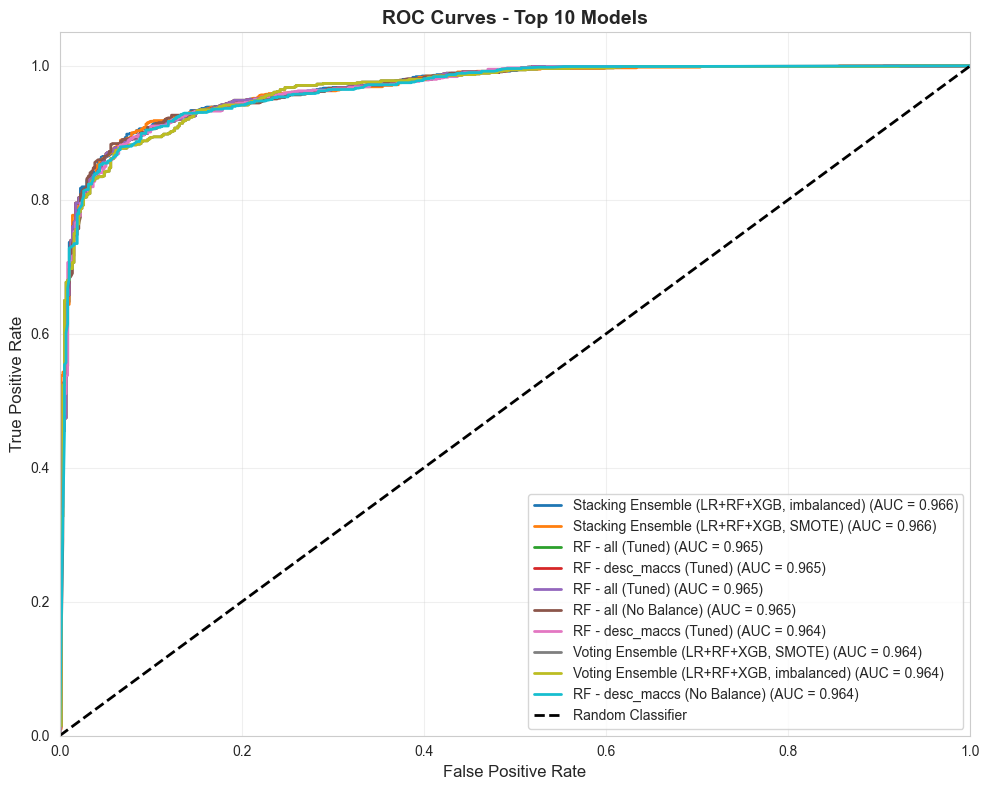

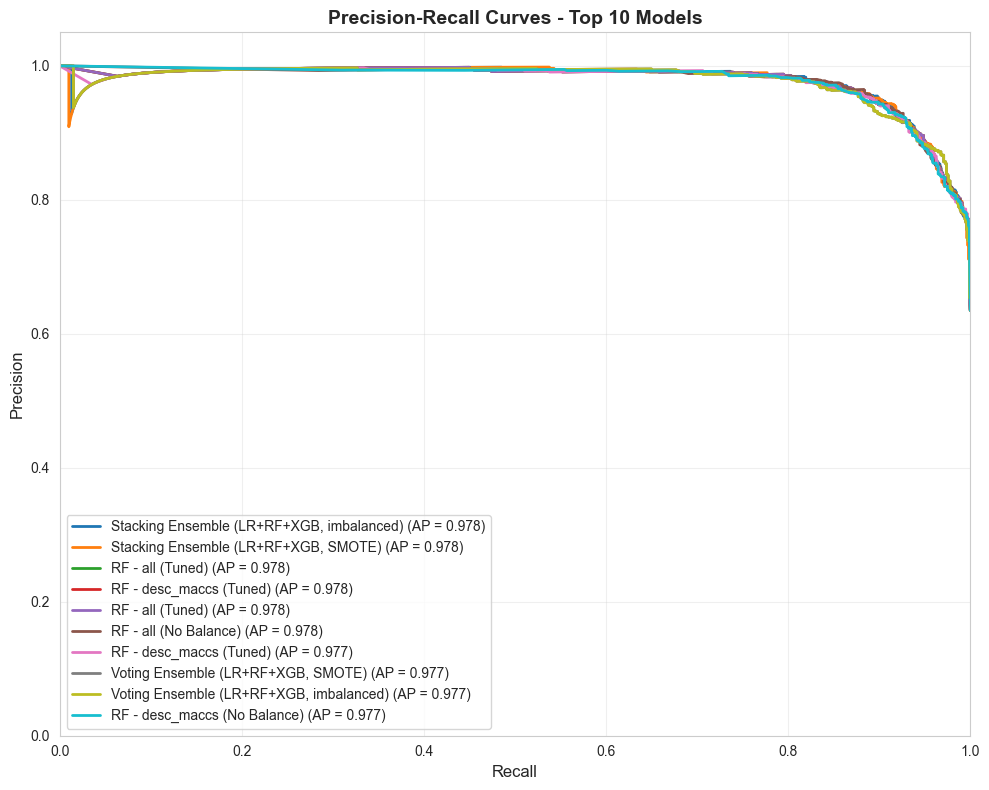

In [70]:
top_10_models = [r for r in sorted(all_results, key=lambda x: x['roc_auc'] if x['roc_auc'] else 0, reverse=True)[:10]]

plot_roc_curve(top_10_models, title="ROC Curves - Top 10 Models")
plot_precision_recall_curve(top_10_models, title="Precision-Recall Curves - Top 10 Models")

### 10.3 Class Imbalance Treatment Comparison

Compare performance with and without class imbalance handling

IMPACT OF CLASS IMBALANCE HANDLING (SMOTE)
              Model  No Balance - Accuracy  SMOTE - Accuracy  No Balance - ROC AUC  SMOTE - ROC AUC  No Balance - F1 (BBB+)  SMOTE - F1 (BBB+)
Logistic Regression               0.878283          0.869955              0.927723         0.924533                0.905754           0.895737
      Random Forest               0.891095          0.902627              0.964954         0.963621                0.916585           0.924528
            XGBoost               0.894939          0.891736              0.959256         0.960515                0.918651           0.916461


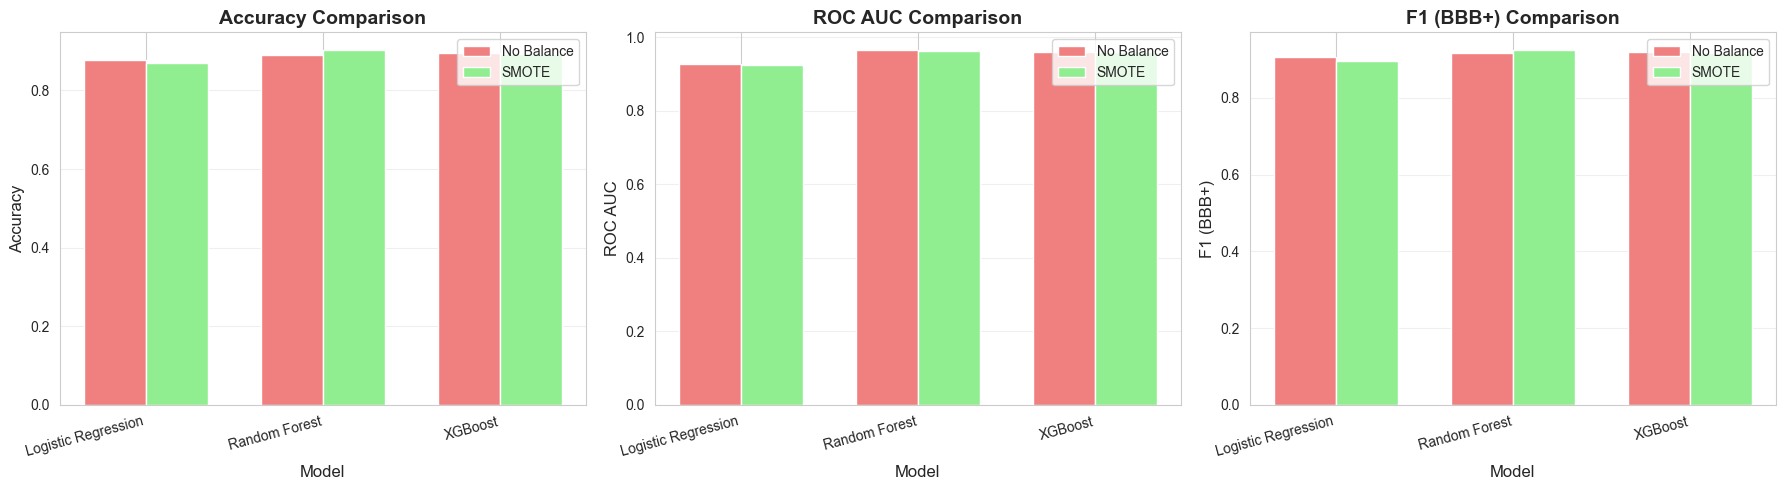

In [72]:

print("IMPACT OF CLASS IMBALANCE HANDLING (SMOTE)")

lr_no_balance = [r for r in lr_results_no_balance if 'all' in r['model_name']][0]
lr_smote = [r for r in lr_results_smote if 'all' in r['model_name']][0]
rf_no_balance = [r for r in rf_results_no_balance if 'all' in r['model_name']][0]
rf_smote = [r for r in rf_results_smote if 'all' in r['model_name']][0]
xgb_no_balance = [r for r in xgb_results_no_balance if 'all' in r['model_name']][0]
xgb_smote = [r for r in xgb_results_smote if 'all' in r['model_name']][0]

imbalance_comparison = pd.DataFrame([
    {
        'Model': 'Logistic Regression',
        'No Balance - Accuracy': lr_no_balance['accuracy'],
        'SMOTE - Accuracy': lr_smote['accuracy'],
        'No Balance - ROC AUC': lr_no_balance['roc_auc'],
        'SMOTE - ROC AUC': lr_smote['roc_auc'],
        'No Balance - F1 (BBB+)': lr_no_balance['f1_class_1'],
        'SMOTE - F1 (BBB+)': lr_smote['f1_class_1']
    },
    {
        'Model': 'Random Forest',
        'No Balance - Accuracy': rf_no_balance['accuracy'],
        'SMOTE - Accuracy': rf_smote['accuracy'],
        'No Balance - ROC AUC': rf_no_balance['roc_auc'],
        'SMOTE - ROC AUC': rf_smote['roc_auc'],
        'No Balance - F1 (BBB+)': rf_no_balance['f1_class_1'],
        'SMOTE - F1 (BBB+)': rf_smote['f1_class_1']
    },
    {
        'Model': 'XGBoost',
        'No Balance - Accuracy': xgb_no_balance['accuracy'],
        'SMOTE - Accuracy': xgb_smote['accuracy'],
        'No Balance - ROC AUC': xgb_no_balance['roc_auc'],
        'SMOTE - ROC AUC': xgb_smote['roc_auc'],
        'No Balance - F1 (BBB+)': xgb_no_balance['f1_class_1'],
        'SMOTE - F1 (BBB+)': xgb_smote['f1_class_1']
    }
])

print(imbalance_comparison.to_string(index=False))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['Accuracy', 'ROC AUC', 'F1 (BBB+)']
for idx, metric in enumerate(metrics):
    no_balance_col = f'No Balance - {metric}'
    smote_col = f'SMOTE - {metric}'
    
    x = np.arange(len(imbalance_comparison))
    width = 0.35
    
    axes[idx].bar(x - width/2, imbalance_comparison[no_balance_col], width, 
                  label='No Balance', color='lightcoral')
    axes[idx].bar(x + width/2, imbalance_comparison[smote_col], width, 
                  label='SMOTE', color='lightgreen')
    
    axes[idx].set_xlabel('Model', fontsize=12)
    axes[idx].set_ylabel(metric, fontsize=12)
    axes[idx].set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(imbalance_comparison['Model'], rotation=15, ha='right')
    axes[idx].legend()
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/imbalance_treatment_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


From above plot, we can conclude that SMOTE did not greatly improve performance of the classifier. 

This could be because we are using high dimensional relatively sparse data, for which SMOTE does not perform as well.

## 11. Summary and Conclusions

Key findings from the experiments:

In [76]:
best_model = comparison_df.iloc[0]

print("EXPERIMENTS SUMMARY")
print(f"\nTotal models evaluated: {len(all_results)}")
print(f"\nBest performing model: {best_model['Model']}")
print(f"   - ROC AUC: {best_model['ROC AUC']:.4f}")
print(f"   - Accuracy: {best_model['Accuracy']:.4f}")
print(f"   - F1 Macro: {best_model['F1 Macro']:.4f}")
print(f"   - Precision (BBB+): {best_model['Precision (BBB+)']:.4f}")
print(f"   - Recall (BBB+): {best_model['Recall (BBB+)']:.4f}")

print(f"\nKey Findings:")
print(f"   1. Feature Representations:")
print(f"      - Combined features (descriptors + fingerprints) generally perform better than fingerprint or descriptors alone.")
print(f"      - Morgan fingerprints perform better in LR, while MACCS outperform in RF and XGB.")


print(f"\n   2. Class Imbalance Handling:")
print(f"    Both class weighting and SMOTE did not improve performance noticeably for any of the models. In some cases, SMOTE even slightly reduced performance, likely due to overfitting on synthetic samples.")
print(f"    This shows how important collection of more data is for this problem, as imbalance handling techniques have limited impact when the dataset is small and the classes are not well represented.")

# Count model types in top 10
lr_count = sum(1 for r in top_10_models if r['model_name'].startswith('LR'))
rf_count = sum(1 for r in top_10_models if r['model_name'].startswith('RF'))
xgb_count = sum(1 for r in top_10_models if r['model_name'].startswith('XGB'))
ensemble_count = sum(1 for r in top_10_models if 'Ensemble' in r['model_name'])

print(f"\n   3. Model Types (in top 10):")
print(f"      - Logistic Regression: {lr_count}")
print(f"      - Random Forest: {rf_count}")
print(f"      - XGBoost: {xgb_count}")
print(f"      - Ensemble: {ensemble_count}")
print(f"    Random Forest models dominate the top 10, suggesting they are particularly effective for this dataset and problem.")

print(f"\n   4. Dimensionality Reduction (PCA):")
print(f"     PCA led to comparable performance while reducing dimensionality significantly for morgan fingerprint based input representations, but led to noticeably worse performance for more dense representations (descriptors, MACCS, combined).\n     This suggests that PCA may be more effective for high-dimensional sparse features like Morgan fingerprints, while it may discard important information in denser feature sets.")



EXPERIMENTS SUMMARY

Total models evaluated: 72

Best performing model: Stacking Ensemble (LR+RF+XGB, SMOTE)
   - ROC AUC: 0.9661
   - Accuracy: 0.9033
   - F1 Macro: 0.8952
   - Precision (BBB+): 0.9183
   - Recall (BBB+): 0.9304

Key Findings:
   1. Feature Representations:
      - Combined features (descriptors + fingerprints) generally perform better than fingerprint or descriptors alone.
      - Morgan fingerprints perform better in LR, while MACCS outperform in RF and XGB.

   2. Class Imbalance Handling:
    Both class weighting and SMOTE did not improve performance noticeably for any of the models. In some cases, SMOTE even slightly reduced performance, likely due to overfitting on synthetic samples.
    This shows how important collection of more data is for this problem, as imbalance handling techniques have limited impact when the dataset is small and the classes are not well represented.

   3. Model Types (in top 10):
      - Logistic Regression: 0
      - Random Forest: 6